测试数据和训练数据分组，数据分batch

In [1]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    # 验证集
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    # 测试集
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

111
31
15


In [2]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# 定义CNN-1D模型
class CNN1DModel(nn.Module):
    def __init__(self, conv_archs, num_classes, input_channels=1):
        super().__init__()
         # CNN参数
        self.conv_arch = conv_archs # 网络结构
        self.input_channels = input_channels # 输入通道数
        self.features = self.make_layers()
        # 平均池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # 线性层
        self.classifier = nn.Linear(conv_archs[-1][-1], num_classes)
        
    # CNN卷积池化结构
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.input_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.input_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2)) # 这里会使宽高减半
        return nn.Sequential(*layers)
    

    def forward(self,input_seq):  # torch.Size([64, 1024])
        batch_size = input_seq.size(0)
        seq_length = input_seq.size(1)

        #改变输入形状，适应网络输入[batch, dim, seq_length]
        input_seq = input_seq.view(batch_size , -1, seq_length)   # torch.Size([64, 1, 1024])
        features = self.features(input_seq)  # [64, 128, 128]
        # print(features.size())  # torch.Size([64, 128, 128])
        x = self.avgpool(features)          # ttorch.Size([64, 128, 1])
        # print(x.size())  # torch.Size([64, 128, 1])
        flat_tensor = x.view(batch_size, -1) # torch.Size([64, 128])
        output = self.classifier(flat_tensor)    # torch.Size([64, 5])
        return output

输入数据的形状是
 1. print(seq.size(), labels.size()) 
 2. torch.Size([64, 1024])   torch.Size([64])

In [3]:
# 定义模型参数
# VGG11，VGG13，VGG16，VGG19 可自行更换。
#conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))  # vgg11
#conv_arch = ((2, 64), (2, 128), (2 , 256), (2, 512), (2, 512))  # vgg13
#conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))  # vgg16
#conv_arch = ((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))  # vgg19
# 先用浅层试一试
conv_arch = ((2, 32), (1, 64), (1, 128))  
input_channels = 1
num_classes = 5

model = CNN1DModel(conv_arch, num_classes, input_channels)  
# 定义损失函数和优化函数 
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
loss_function = loss_function.to(device)
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    96
    32
  3072
    32
  6144
    64
 24576
   128
   640
     5
______
 34789


In [4]:
print(model)

CNN1DModel(
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): ReLU(inplace=True)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): ReLU(inplace=True)
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (classifier): Linear(in_features=128, out_features=5, bias=True)
)


注意调整参数，
1. 可以适当增加 cnn层数 和每层神经元个数，微调学习率；
2. 增加更多的 epochs,  （注意防止过拟合）

Epoch:  1 train_Loss: 1.61020568 train_Accuracy:0.1990
Epoch:  1 val_Loss:1.61007810,  validate_Acc:0.2006
Epoch:  2 train_Loss: 1.60996074 train_Accuracy:0.1990
Epoch:  2 val_Loss:1.60983387,  validate_Acc:0.1935
Epoch:  3 train_Loss: 1.60978959 train_Accuracy:0.1966
Epoch:  3 val_Loss:1.60948066,  validate_Acc:0.1925
Epoch:  4 train_Loss: 1.60961739 train_Accuracy:0.1969
Epoch:  4 val_Loss:1.61000551,  validate_Acc:0.2021
Epoch:  5 train_Loss: 1.60934660 train_Accuracy:0.2043
Epoch:  5 val_Loss:1.60940745,  validate_Acc:0.1925
Epoch:  6 train_Loss: 1.60922386 train_Accuracy:0.1983
Epoch:  6 val_Loss:1.60928900,  validate_Acc:0.1890
Epoch:  7 train_Loss: 1.60833238 train_Accuracy:0.2043
Epoch:  7 val_Loss:1.60790323,  validate_Acc:0.2016
Epoch:  8 train_Loss: 1.60771149 train_Accuracy:0.2010
Epoch:  8 val_Loss:1.60723822,  validate_Acc:0.1830
Epoch:  9 train_Loss: 1.60690418 train_Accuracy:0.2054
Epoch:  9 val_Loss:1.60709503,  validate_Acc:0.2026
Epoch: 10 train_Loss: 1.60755651 trai

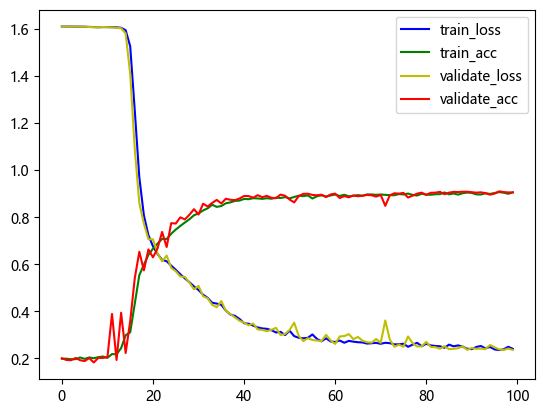

best_accuracy : 0.9097782258064516


In [5]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, train_loader, val_loader, model, optimizer, loss_function):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            loss_validate = 0.
            correct_validate = 0
            # 将模型设置为评估模式
            model.eval()
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

    
    # 保存最后的参数
    # torch.save(model, 'final_model_cnn1d.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_cnn1d.pt')
   
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)



batch_size = 64
epochs = 100
# 模型训练
model_train(batch_size, epochs, train_loader, val_loader, model, optimizer, loss_function)

In [6]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model_cnn1d.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       202
           1     0.8564    0.9153    0.8849       189
           2     0.8280    0.8021    0.8148       192
           3     0.8511    0.8377    0.8443       191
           4     0.9505    0.9301    0.9402       186

    accuracy                         0.8979       960
   macro avg     0.8972    0.8970    0.8969       960
weighted avg     0.8981    0.8979    0.8977       960



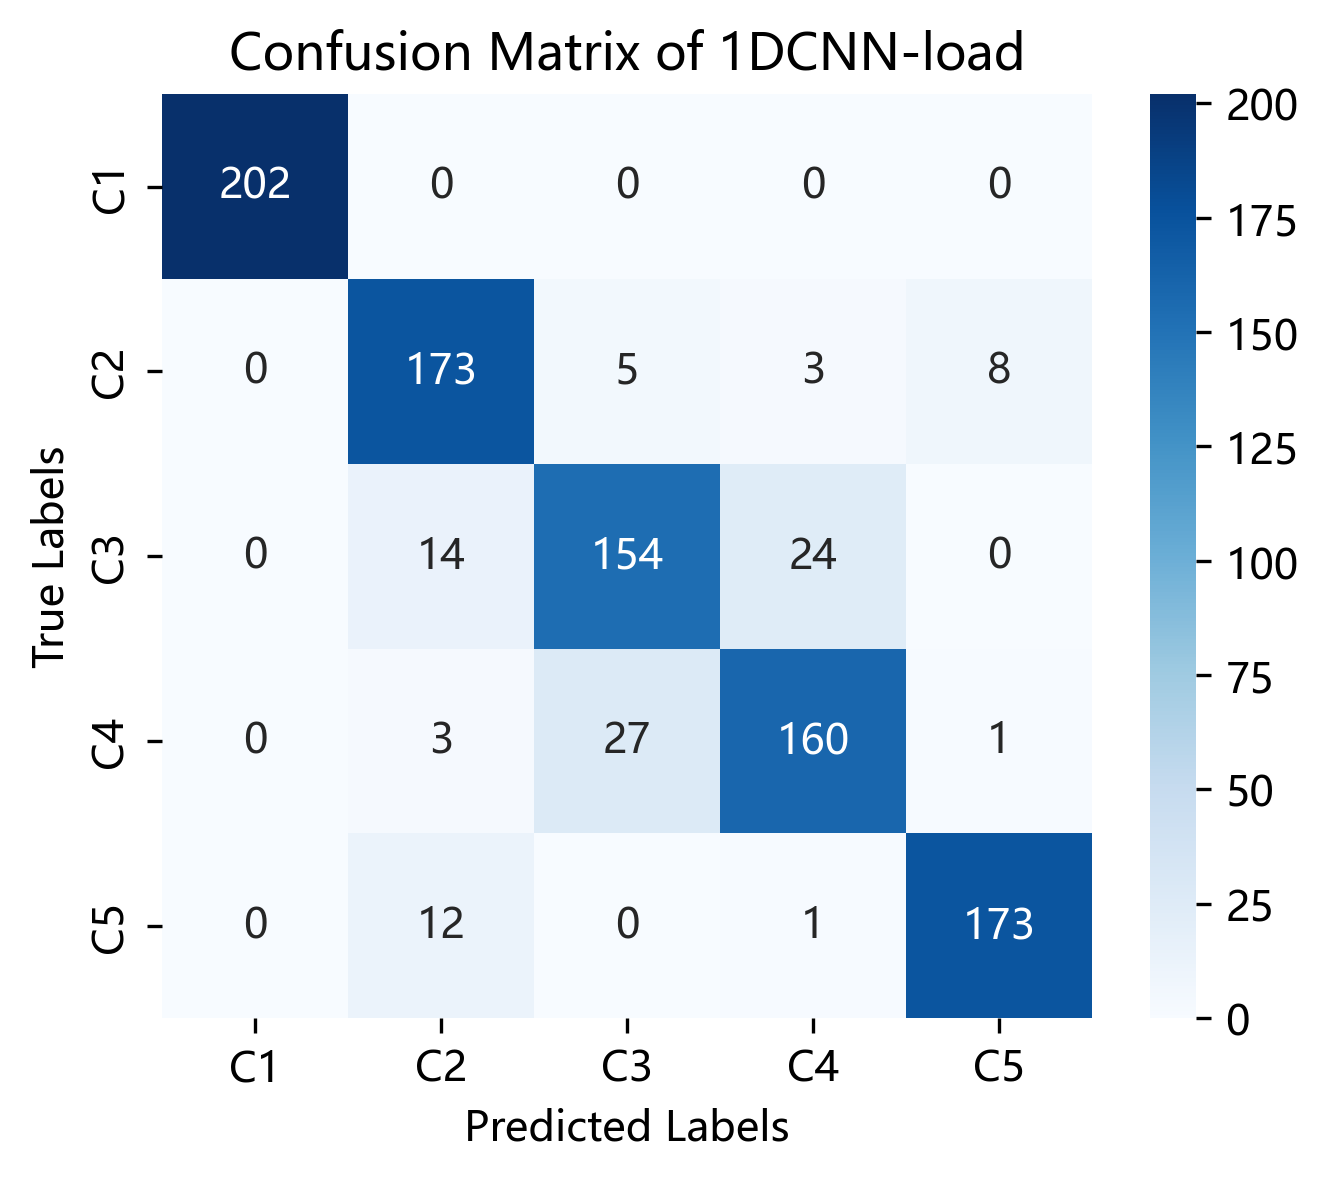

In [7]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
}

# 绘制混淆矩阵
plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of 1DCNN-load')
plt.savefig("cnn1d_confusion.png")
plt.show()

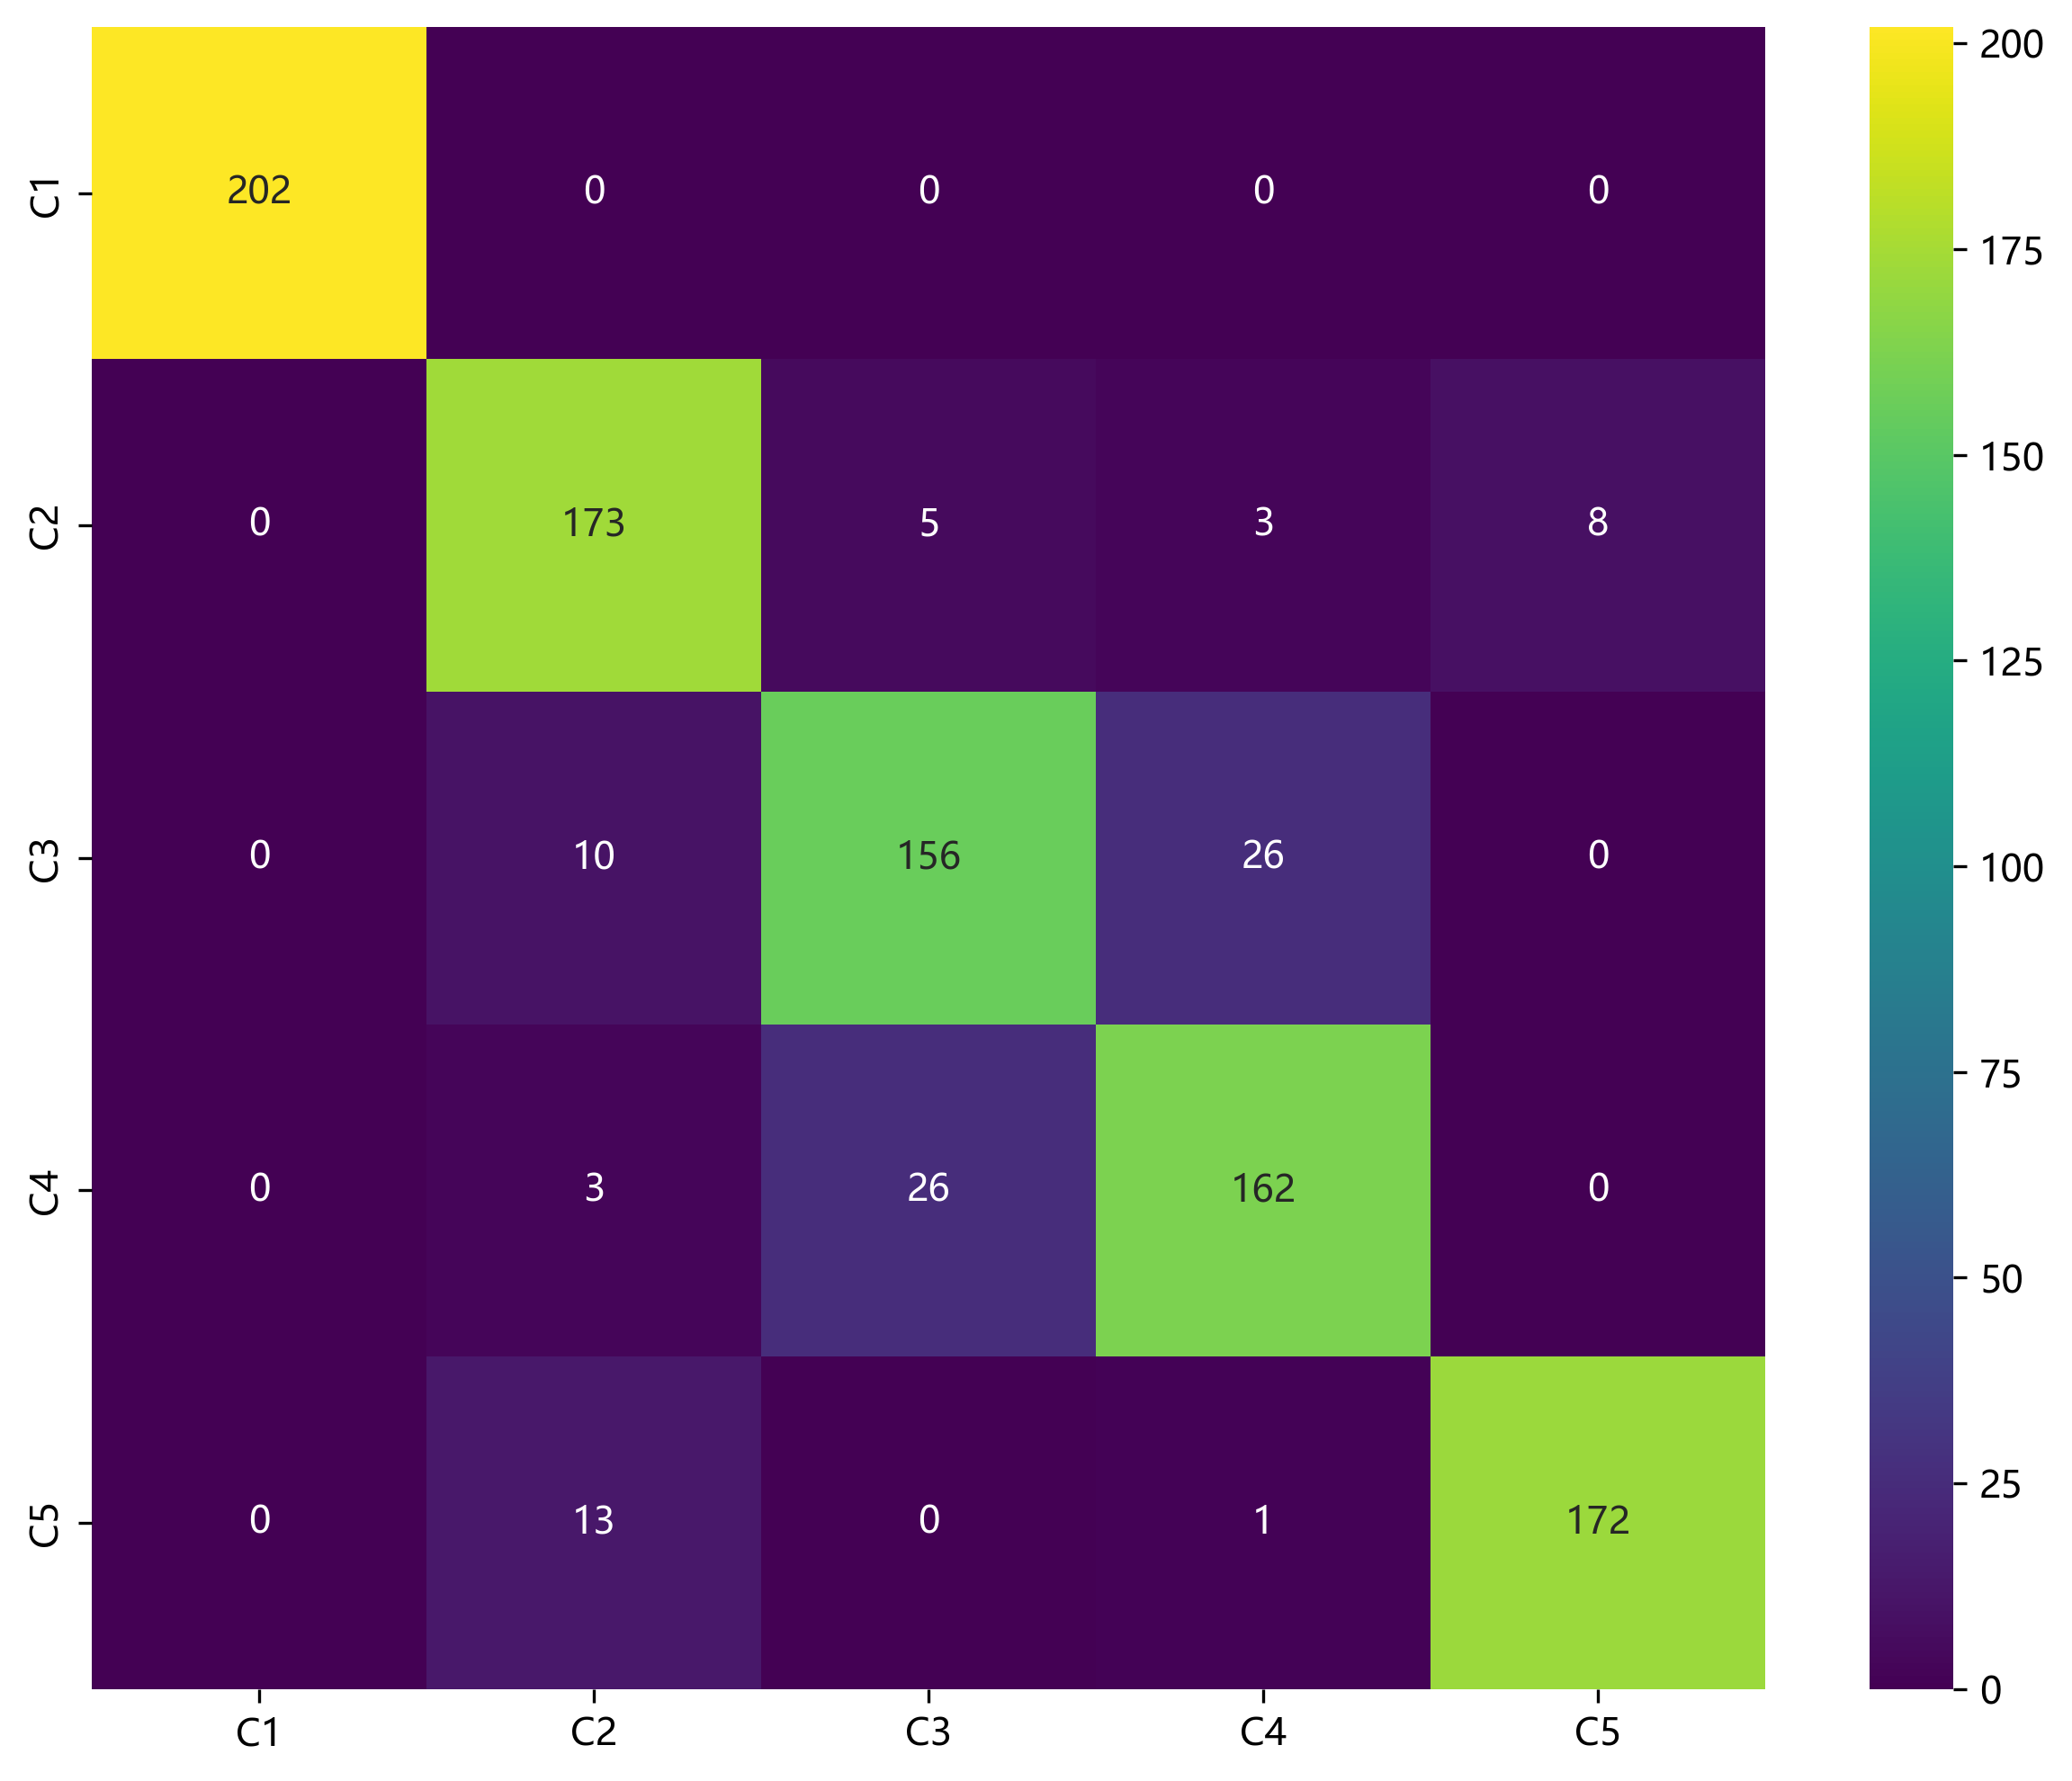

In [8]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
}

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='viridis')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()